In [38]:
import matplotlib.pyplot as plt
import seaborn as sns 
import subprocess
import pandas as pd
import numpy as np

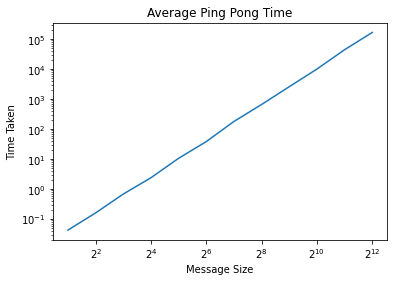

In [10]:
header = ['Processors', 'Message Size', 'Time Taken']
data = pd.read_csv('example.csv', header=0)
data.columns = header
data.head()

processors = data['Processors']
messageSize = data['Message Size']
time = data['Time Taken']
iterations = 100

avgCommunicationTime = time / iterations

plt.figure()
plt.plot(messageSize, avgCommunicationTime)
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size')
plt.ylabel('Time Taken')
plt.show()

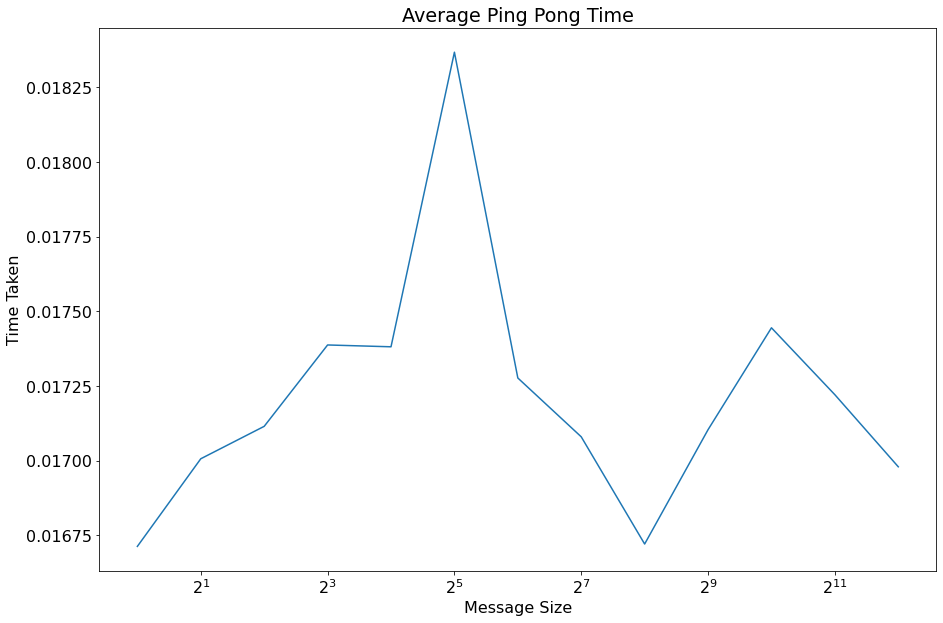

In [47]:
# Data Collection
header = ['Processors', 'Message Size', 'Time Taken']
data = pd.read_csv('ping_pong_blocking.csv', header=0)
data.columns = header

# Sorting &  Labeling
dataSorted = data.sort_values(by='Message Size')
processors = dataSorted['Processors']
uniqueMessageSizes = dataSorted['Message Size'].unique()

# Uncomment to only include Message Sizes up to 4096 Bytes
# dataSorted = dataSorted[dataSorted['Message Size'] <= 4096]
# processors = dataSorted['Processors']
# uniqueMessageSizes = dataSorted['Message Size'].unique()

# For Each Message Size, Get The Average Time
avgTimeData = np.array([np.mean(dataSorted[dataSorted['Message Size'] == aMessageSize]['Time Taken']) for aMessageSize in uniqueMessageSizes])
iterations = 100
avgCommunicationTime = avgTimeData / iterations

# Visualization
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,10))
plt.plot(uniqueMessageSizes[:13], avgCommunicationTime[:13])
plt.xscale('log', base=2)
# plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size')
plt.ylabel('Time Taken')
plt.show()

In [42]:
# Data Collection
header = ['Processors', 'Message Size', 'Time Taken']
data = pd.read_csv('ping_pong_nonblocking.csv', header=0)
data.columns = header

# Sorting &  Labeling
dataSorted = data.sort_values(by='Message Size')
# dataLimitDataSize = dataSorted[dataSorted['Message Size'] <= 4096]
processors = dataSorted['Processors']
uniqueMessageSizes = dataSorted['Message Size'].unique()
# messageSizeLimitDataSize = dataLimitDataSize['Message Size'].unique()

# For Each Message Size, Get The Average Time
avgTimeData = np.array([np.mean(dataSorted[dataSorted['Message Size'] == aMessageSize]['Time Taken']) for aMessageSize in uniqueMessageSizes])
iterations = 100
avgCommunicationTime = avgTimeData / iterations

# Visualization
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,10))
plt.plot(uniqueMessageSizes, avgCommunicationTime)
plt.xscale('log', base=2)
plt.yscale('log')
plt.title('Average Ping Pong Time')
plt.xlabel('Message Size')
plt.ylabel('Time Taken')
plt.show()

EmptyDataError: No columns to parse from file